# Importing libraries

In [0]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
import os.path

resume_weights = "/content/drive/My Drive/22-2/checkpoint_CIFAR_2.pth.tar"
cuda = torch.cuda.is_available()

In [0]:
transform = transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ])

# Preparing data

In [0]:
torch.backends.cudnn.deterministic = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [38]:
trainset = datasets.CIFAR10('/data', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('/data', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [39]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)
print(labels)

torch.Size([4, 3, 32, 32])
torch.Size([4])
tensor([0, 5, 4, 4])


In [40]:
print(images[0].shape)

torch.Size([3, 32, 32])


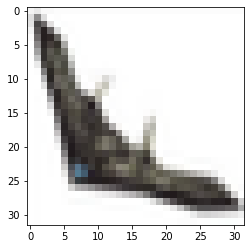

In [41]:
npimg = images[0]
npimg = npimg/2 + 0.5
plt.imshow(np.transpose(npimg, (1,2,0)))

In [0]:
best_accuracy = torch.FloatTensor([0])
start_epoch = 0

plane   dog  deer  deer


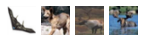

In [43]:
num_of_images = 4
for index in range(1, num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  #print(classes[labels[index-1]])
  npimg = images[index-1]
  npimg = npimg/2 + 0.5
  plt.imshow(np.transpose(npimg, (1,2,0)))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Defining the Network

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [45]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3,32,3)
    self.conv2 = nn.Conv2d(32,32,3)
    self.bn1 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(2,2)
    self.drop = nn.Dropout(0.2)
    self.drop2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(14*14*32,512)
    self.fc2 = nn.Linear(512,10)
  
  def forward(self,x):
    x = self.drop(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn1(self.conv2(x))))
    x = x.view(-1,14*14*32)
    x = F.relu(self.fc1(x))
    x = self.drop2(x)
    x = self.fc2(x)
    x = F.log_softmax(x,dim=1)
    return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.01)

# Saving model

In [0]:
def save_checkpoint(state, is_best, filename = resume_weights):
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [48]:
if os.path.isfile(resume_weights):
    print("=> loading checkpoint '{}' ...".format(resume_weights))
    #if cuda:
    checkpoint = torch.load(resume_weights)
    #else:
     #   checkpoint = torch.load(resume_weights,
      #                          map_location=lambda storage,
       #                         loc: storage)
    start_epoch = checkpoint['epoch']
    best_accuracy = checkpoint['best_accuracy']
    print('=> loaded checkpoint {} (trained for {} epochs) with {:.4}% test accuracy'.format(resume_weights,
        checkpoint['epoch'],100 * best_accuracy.numpy()[0]))
    net.load_state_dict(checkpoint['state_dict'])
else:print("no") 

=> loading checkpoint '/content/drive/My Drive/22-2/checkpoint_CIFAR_2.pth.tar' ...
=> loaded checkpoint /content/drive/My Drive/22-2/checkpoint_CIFAR_2.pth.tar (trained for 4 epochs) with 69.62% test accuracy


# Forward loop

In [0]:
def eval():
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
   for data in testloader:
     images, labels = data[0].to(device), data[1].to(device)
     outputs = net(images)
     _, predicted = torch.max(outputs,1)
     total += labels.size(0)
     correct  += (predicted == labels).sum().item()

  acc = correct/total
#print('Accuracy of the network over 10000 test images: %d %%' %(100  * correct/total))
  return acc

In [52]:
for epochs in range(1,3):

  running_loss = 0.0
  correct= 0
  total = 0

  for i, data in enumerate(trainloader,0):
      inputs, labels = data[0].to(device), data[1].to(device)
      
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      

      running_loss += loss.item()
      if i % 2000 == 1999:
            print('[%d, %5d] loss : %.3f acc: %.3f %%' % (epochs, i+1, running_loss/2000, correct/total *100))
            running_loss = 0.0
            correct = 0
            total = 0
  acc1 = eval()
  print ('epoch: %d acc_test: %.3f %%' % (epochs, acc1*100))
  acc1 = torch.FloatTensor([acc1])
  is_best = bool(acc1.numpy() > best_accuracy.numpy())
  best_accuracy = torch.FloatTensor(max(acc1.numpy(), best_accuracy.numpy()))
  save_checkpoint({
      'epoch' : start_epoch + epochs,
      'state_dict' : net.state_dict(),
      'best_accuracy' : best_accuracy
      }, is_best)
  
print('Finished training')

[1,  2000] loss : 0.452 acc: 84.763 %
[1,  4000] loss : 0.414 acc: 85.600 %
[1,  6000] loss : 0.407 acc: 86.037 %
[1,  8000] loss : 0.420 acc: 85.088 %
[1, 10000] loss : 0.410 acc: 85.825 %
[1, 12000] loss : 0.409 acc: 85.500 %
epoch: 1 acc_test: 70.050 %
=> Saving a new best
[2,  2000] loss : 0.170 acc: 94.688 %
[2,  4000] loss : 0.190 acc: 93.337 %
[2,  6000] loss : 0.223 acc: 91.888 %
[2,  8000] loss : 0.231 acc: 92.138 %
[2, 10000] loss : 0.271 acc: 90.700 %
[2, 12000] loss : 0.267 acc: 90.825 %
epoch: 2 acc_test: 69.010 %
=> Validation Accuracy did not improve
Finished training
